In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from skimage import io
import numpy as np
from skimage.transform import rescale, resize
from PIL import Image 

import matplotlib.pyplot as plt
from collections import *


#%pylab inline
import glob
import sys
import os
from collections import OrderedDict
import caffe
base_dir = os.getcwd()
sys.path.append(base_dir)
from DeepImageSynthesis import *
VGGweights = os.path.join(base_dir, 'Models/vgg_normalised.caffemodel')
VGGmodel = os.path.join(base_dir, 'Models/VGG_ave_pool_deploy.prototxt')
imagenet_mean = np.array([ 0.40760392,  0.45795686,  0.48501961]) #mean for color channels (bgr)
im_dir = os.path.join(base_dir, 'Images/')
gpu = 0
caffe.set_mode_gpu() #for cpu mode do 'caffe.set_mode_cpu()'
caffe.set_device(gpu)

/home/x227guo/.virtualenvs/a613/lib/python3.6/site-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


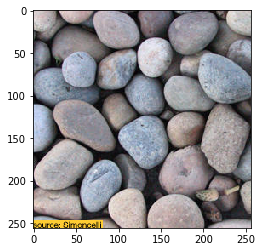

In [2]:
#load source image
source_img_name = glob.glob1(im_dir, 'pebbles.jpg')[0]
source_img_org = caffe.io.load_image(im_dir + source_img_name)
im_size = 256.
[source_img, net] = load_image(im_dir + source_img_name, im_size, 
                            VGGmodel, VGGweights, imagenet_mean, 
                            show_img=True)
im_size = np.asarray(source_img.shape[-2:])

(256, 256, 3)
<class 'numpy.ndarray'>
(1, 3, 256, 256)
<class 'numpy.ndarray'>


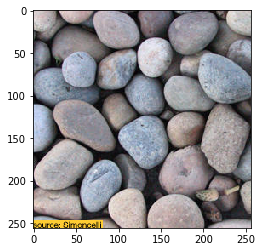

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


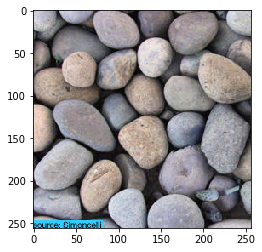

In [3]:
print(source_img_org.shape)
print(type(source_img_org))   
print((source_img).shape)
print(type(source_img))

nm = imagenet_mean[:,np.newaxis,np.newaxis] 
plt.imshow(source_img_org)    # [0-1]rgb
plt.show()
plt.figure()
plt.imshow(np.transpose(source_img[0,:,:,:]/255+nm,(1,2,0)))  # [0-255] SUBTACT MEAN BGR
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'> (256, 256, 3) 255 0


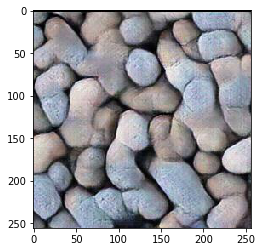

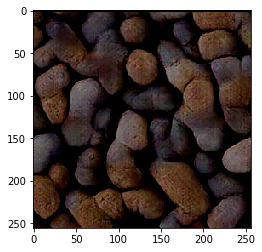

In [17]:
seed = 100
np.random.seed(seed)
nm1 = imagenet_mean[np.newaxis,np.newaxis,:]




ii = io.imread('01_pebbles.jpg')
ii = np.asarray(ii)
print(type(ii),ii.shape,ii.max(),ii.min())

###################################BGR
imgn = ii[...,::-1]/255
imgn = imgn - nm1

imgn = np.transpose(imgn,(2,0,1))
imgn = imgn[np.newaxis,...]*255

plt.imshow(ii)
plt.figure()
plt.imshow(np.transpose(imgn[0,:,:,:]/255,(1,2,0)))






nc = 3
image_height = 256
image_width = 256

# noise = np.random.randn(image_height,image_width,nc)*(2**k)/255

# imgn = noise + source_img_org   # org RGB
# imgn = np.clip(imgn,0,1)

# nm1 = imagenet_mean[np.newaxis,np.newaxis,:]
# imgn = imgn[...,::-1]
# imgn = imgn - nm1
# imgn = np.transpose(imgn*255,(2,0,1))
# imgn = imgn[np.newaxis,:,:,:]

In [18]:
print(source_img.shape,imgn.shape)

(1, 3, 256, 256) (1, 3, 256, 256)


In [19]:
print(type(source_img),source_img.max(), source_img.min(), np.mean(source_img))

<class 'numpy.ndarray'> 151.061 -123.68001 19.741419


In [20]:
print(type(imgn),imgn.max(), imgn.min(), np.mean(imgn))

<class 'numpy.ndarray'> 151.0610004 -123.68000055 24.243833964257814


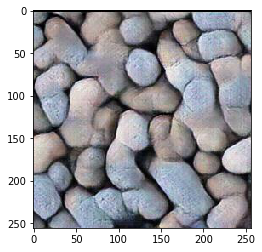

In [21]:
ss = imgn[0,:,:,:]
ss = np.transpose(ss,(1,2,0))
ss = ss/255+nm1

##############################RGB
ss = ss[...,::-1]


plt.imshow(ss)  
plt.show()

In [22]:
#l-bfgs parameters optimisation
maxiter = 2000
m = 20

#define layers to include in the texture model and weights w_l
tex_layers = ['pool4', 'pool3', 'pool2', 'pool1', 'conv1_1']
tex_weights = [3e6,3e6,3e6,3e6,3e6]

#pass image through the network and save the constraints on each layer
constraints = OrderedDict()
net.forward(data = source_img)
for l,layer in enumerate(tex_layers):
    constraints[layer] = constraint([LossFunctions.gram_mse_loss],
                                    [{'target_gram_matrix': gram_matrix(net.blobs[layer].data),
                                     'weight': tex_weights[l]}])
    
#get optimisation bounds
bounds = get_bounds([source_img],im_size)
#print(bounds)
#generate new texture
# result = mpool5(net, constraints, init = noise ,bounds=bounds,
#                   callback=lambda x: show_progress(x,net), 
#                   minimize_options={'maxiter': maxiter,
#                                     'maxcor': m,
#                                     'ftol': 0, 'gtol': 0})

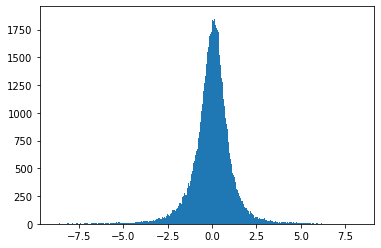

499692.40228972986
gg 8.303610801696777 -8.875778198242188 0.7781027021357954


In [23]:
ll, gg = mpool5(net, constraints, init = imgn)
plt.hist(gg,1000)
plt.show()
print(ll)
print('gg',gg.max(),gg.min(),np.mean(np.absolute(gg)))

In [24]:
matt(imgn,source_img)

(array(6211.0728, dtype=float32),
 array([-2.1972656, -2.105713 , -2.105713 , ..., -1.2715658, -1.4241537,
        -1.6581218], dtype=float32))

In [25]:
27693/499692

0.05542013880550419

In [26]:
2413/6211

0.3885042666237321

iter 0
loss0: 13146.079
loss1 499615.78222327266


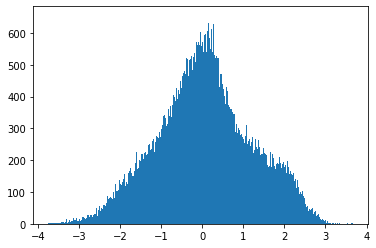

g1 3.6616232 -3.743312 0.923179


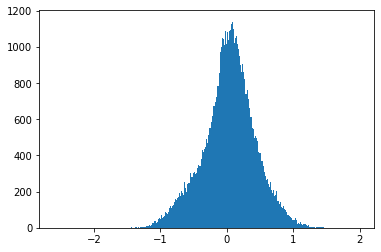

gkeep 1.9896420240402222 -2.588048219680786 0.3064875077267626


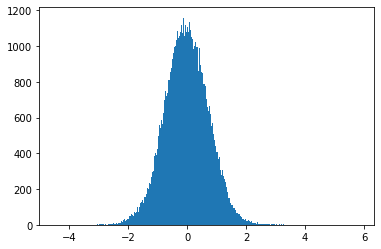

gm 5.8308512129788035 -4.4922881472781375 0.5893470275122037
xm-x: -10315.927643180132
gn 4.9537177085876465 -4.320517063140869 0.426247019568633
comp 35837.728063705435
v temp_comp -2.0 15729.694175130338
v temp_comp -1.849624060150376 16099.65715865622
v temp_comp -1.699248120300752 15945.482885248784
v temp_comp -1.5488721804511278 15220.725112523243
v temp_comp -1.3984962406015038 13857.597626194067
v temp_comp -1.2481203007518795 11840.49574294017
v temp_comp -1.0977443609022557 9113.890469161095
v temp_comp -0.9473684210526314 5625.302219667647
v temp_comp -0.7969924812030074 1362.8300183553947
v temp_comp -0.6466165413533833 3697.4311522657517
v temp_comp -0.49624060150375926 9627.236644440156
v temp_comp -0.3458646616541352 16474.166918039264
v temp_comp -0.19548872180451116 24256.36911609629
v temp_comp -0.045112781954887105 33014.5520008881


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y-x -15983.430751844608


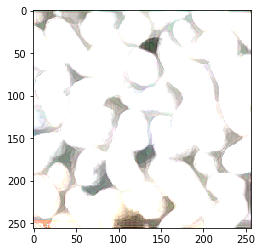

cumulate comp: 27.41628626571037
############################# 

loss0: 13363.695
loss1 499588.36593700695


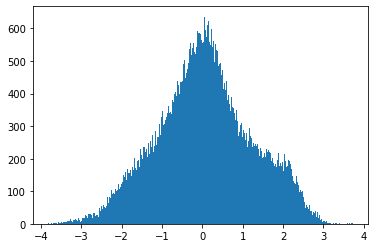

g1 3.7251873 -3.8213818 0.9316552


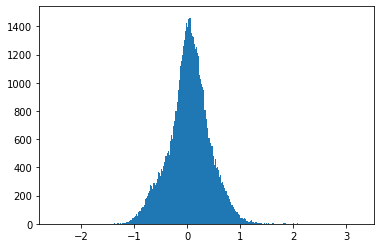

gkeep 3.2385635375976562 -2.4974639415740967 0.300619254343677


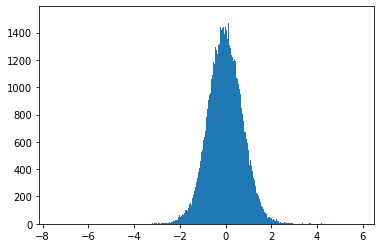

gm 5.833356829495504 -7.4748524314895555 0.5959910462692278
xm-x: -12354.696146753737
gn 4.01162052154541 -6.806814193725586 0.39965084745552204
comp 42213.91088653583
v temp_comp -2.0 16217.24413223035
v temp_comp -1.849624060150376 14856.849821608514
v temp_comp -1.699248120300752 13084.141634496802
v temp_comp -1.5488721804511278 10896.557733217429
v temp_comp -1.3984962406015038 8266.25291242305
v temp_comp -1.2481203007518795 5164.227638619079
v temp_comp -1.0977443609022557 1558.9934719575103
v temp_comp -0.9473684210526314 2569.4032586208195
v temp_comp -0.7969924812030074 7240.289582347672
v temp_comp -0.6466165413533833 12482.802183337219
v temp_comp -0.49624060150375926 18325.77295597276
v temp_comp -0.3458646616541352 24789.283769386297
v temp_comp -0.19548872180451116 31917.13985545683
v temp_comp -0.045112781954887105 39731.188438966


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y-x -20324.041514740402


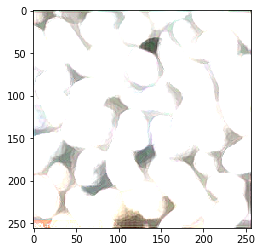

cumulate comp: 55.88702367799124
############################# 

loss0: 13569.386
loss1 499616.83667441923


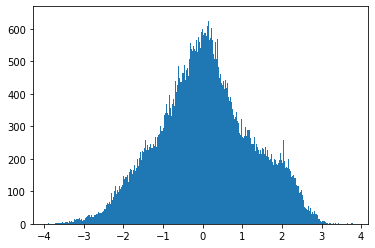

g1 3.7864416 -3.8964922 0.93963975


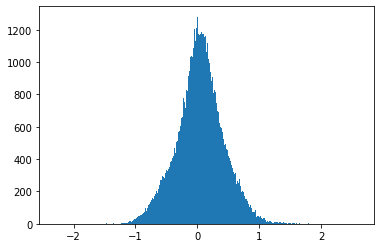

gkeep 2.61008358001709 -2.304874897003174 0.29480248940653747


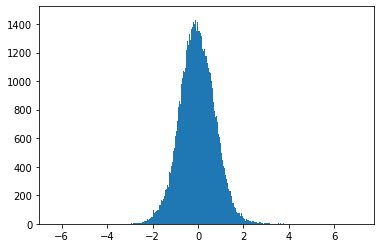

gm 7.084364725386031 -6.3096369168457365 0.6107510053910318
xm-x: -15491.814371501894
gn 6.531424522399902 -9.34034538269043 0.5739833775476907
comp 66655.64270768932
v temp_comp -2.0 39784.74518544192
v temp_comp -1.849624060150376 33163.39765360439
v temp_comp -1.699248120300752 27077.720560755813
v temp_comp -1.5488721804511278 21680.443006761547
v temp_comp -1.3984962406015038 17276.605052461266
v temp_comp -1.2481203007518795 13946.109872682078
v temp_comp -1.0977443609022557 11889.41353607364
v temp_comp -0.9473684210526314 11483.607776253542
v temp_comp -0.7969924812030074 13026.033165364235
v temp_comp -0.6466165413533833 16793.185861114413
v temp_comp -0.49624060150375926 23145.54768239474
v temp_comp -0.3458646616541352 32404.85473913164
v temp_comp -0.19548872180451116 44926.727878683596
v temp_comp -0.045112781954887105 61066.18151632743
y-x -22580.31439142835


In [55]:
device = 'cuda:0'
iteration = 1000

# mkeep = mse
# matt = mpool5

mkeep = mpool5
matt = mse
#z = imgn
#z = tt
cu = 0
L = []
nc = 3
for i in range(iteration):
    
    if i%10 == 0:
        print('iter', i)
    
    #loss0, g1 = matt(net, constraints, z)
    loss0, g1 = matt(z,source_img)
   
    L.append(loss0)
    print('loss0:', loss0)
    
    #loss1, gkeep = mkeep(z,source_img)
    loss1, gkeep = mkeep(net, constraints, z)
    print('loss1',loss1)

    plt.hist(g1,1000)
    plt.show()
    print('g1',g1.max(),g1.min(),np.mean(np.absolute(g1)))
    plt.hist(gkeep,1000)
    plt.show()
    print('gkeep',gkeep.max(),gkeep.min(),np.mean(np.absolute(gkeep)))
    
    t, comp = search_grad(source_img, g1, gkeep, z, mkeep = mkeep, lamda = 2.5)
    
    if comp > 100:
        np.save('mw_imgn.npy',z)  
        break
        
    
    plt.imshow(np.transpose((t[0,:,:,:]-t.min())/255,(1,2,0)))
    plt.show()
    #t = np.subtract(z.flatten(), np.multiply(lamda, g1))
    cu += comp
    
    print('cumulate comp:',cu)
    t = t.reshape(1,nc,image_height,image_width)
    #display_img(t)
    print('#############################','\n')
    #if i%2 == 0:
    #    t = np.clip(t,imgn.min(),imgn.max())
    
   
    z = t
    

In [183]:
np.mean(imgn)

19.99280134534705

In [39]:
# savings


zz = z  #####
np.save('mw_imgn.npy',zz)

In [387]:
#t = tt*255
#z = np.load('mw_imgn.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


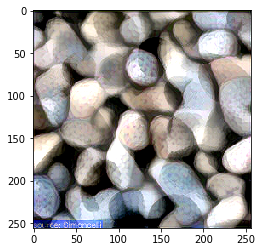

In [56]:
tt = z
tt = np.clip(tt,imgn.min(),imgn.max())
tt = tt[0,:,:,:]
tt = np.transpose(tt,(1,2,0))
tt = tt/255 + nm1
tt = tt[...,::-1]
plt.imshow(tt)
plt.savefig('b5.jpg',dpi = 300)
plt.show()

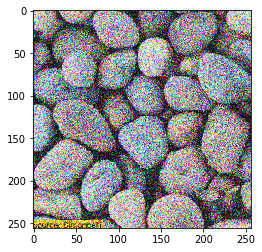

In [153]:
ss = imgn[0,:,:,:]
ss = np.transpose(ss,(1,2,0))
ss = ss/255+nm1
ss = ss[...,::-1]

plt.imshow(ss)  
plt.savefig('a3.jpg',dpi = 300)
plt.show()

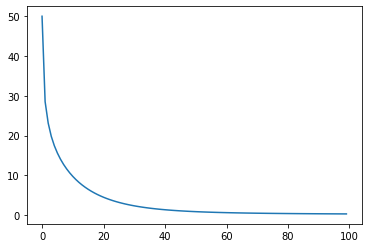

In [70]:
plt.plot(L)

In [54]:

"""

noise iamge       reference image


"""
def mse(im,img):

    if isinstance(im,np.ndarray):
        im = torch.from_numpy(im).float()
        im.to(device)
        im.requires_grad = True

    if isinstance(img,np.ndarray):
        img = torch.from_numpy(img).float()
        img.to(device)
        img.requires_grad = True

    im.requires_grad = True
    N = nc*image_height*image_width
    loss = ((im-img)**2).sum() / (N)
    loss.backward()

    return loss.detach().numpy(), im.grad.detach().numpy().flatten()*1000

def search_grad(o, g1, gkeep, x = None, mkeep = None, lamda = None):
    
    #r = 1
    #step = 0.0001
    r = 1
    step = 0.003
    N = 2*r/step
    vsearch = np.linspace(-2*r,0*r,N)
    # _, nc, _, _ = x.shape 
    
    
    #####   project
    gm = g1 - np.multiply(np.divide(np.dot(g1,gkeep), np.dot(gkeep,gkeep)) ,gkeep)
    plt.hist(gm, 1000)
    plt.show()
    print('gm',gm.max(),gm.min(),np.mean(np.absolute(gm)))
    
    
    ################# 
    #xm = np.subtract(x.flatten(), np.multiply(lamda, gm)).reshape(1,nc,image_height,image_width)
    xm = np.add(x.flatten(), np.multiply(lamda, gm)).reshape(1,nc,image_height,image_width)
    
    print('xm-x:', (xm-x).sum())
   
    y = xm
    
    ####################################
    #m0, _ = mkeep(x, o)
    m0,_ = mkeep(net, constraints, x)
    #m1, gn = mkeep(xm, o)
    m1, gn = mkeep(net, constraints, xm)
    print('gn',gn.max(),gn.min(),np.mean(np.absolute(gn)))
    comp = np.absolute(m1-m0)
    print('comp',comp)
    for i,v in enumerate(vsearch):
       # print('v:',v)
        temp_im = xm.flatten() + v*gn
        temp_im = temp_im.reshape(1,nc,image_height,image_width)
        #print('temp_im-xm:', (temp_im-xm).sum())
        #temp_mkeep, _ = mkeep(temp_im, o)
        temp_mkeep, _ = mkeep(net, constraints, temp_im)
        temp_comp =  np.absolute(temp_mkeep-m0)
        if i%50 == 0:
            print('v temp_comp',v,temp_comp)
        if temp_comp  < comp:
           # print('!',v)
            comp = temp_comp
            y = temp_im
    print('y-x',(y-x).sum())        
    return y, comp

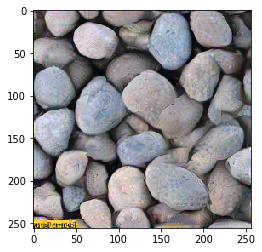

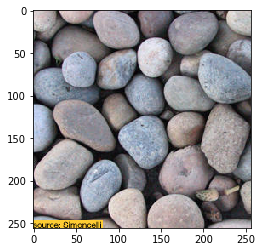

In [9]:
#match histogram of new texture with that of the source texture and show both images
new_texture = result['x'].reshape(*source_img.shape[1:]).transpose(1,2,0)[:,:,::-1]
new_texture = histogram_matching(new_texture, source_img_org)
imshow(new_texture)
figure()
imshow(source_img_org)